## Loading Data and Summarizing
First, the data is loaded and we summarize clean energy capacity by HDI code.

In [1]:
elecdata <- read.csv("../../Data/unified/data_unified_raw.csv", na.strings=c("","NA"))

library(dplyr)
library(tidyr)
library(ggpubr)
library(ggplot2)

hdi_levels <- c("Low", "Medium", "High", "Very High")
elecdata <- elecdata %>% 
  mutate(HDICode = factor(HDICode, levels = hdi_levels, ordered = T),
         CapCleanProportion = CapClean / CapTotal,
         CapFossilProportion = CapFossil / CapTotal)


summary(elecdata %>% select(HDICode, CapCleanProportion, CapFossilProportion))

package 'dplyr' was built under R version 4.3.1



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



package 'ggpubr' was built under R version 4.3.1


Loading required package: ggplot2


package 'ggplot2' was built under R version 4.3.1


      HDICode     CapCleanProportion CapFossilProportion
 Low      : 692   Min.   :0.00000    Min.   :0.0000     
 Medium   : 899   1st Qu.:0.02113    1st Qu.:0.4259     
 High     :1056   Median :0.30860    Median :0.6914     
 Very High:1381   Mean   :0.34853    Mean   :0.6515     
 NA's     : 660   3rd Qu.:0.57408    3rd Qu.:0.9789     
                  Max.   :1.00000    Max.   :1.0000     
                  NA's   :193        NA's   :193        

In [2]:
elecdata %>% 
  filter(!is.na(HDICode)) %>%
  group_by(HDICode) %>%
  summarise(CapCleanProportion = mean(CapCleanProportion, na.rm = T),
            CapFossilProportion = mean(CapFossilProportion, na.rm = T),
            n = n())

# A tibble: 4 × 4
  HDICode   CapCleanProportion CapFossilProportion     n
  <ord>                  <dbl>               <dbl> <int>
1 Low                    0.401               0.599   692
2 Medium                 0.456               0.544   899
3 High                   0.265               0.735  1056
4 Very High              0.391               0.609  1381

Interestingly, Low and Medium HDI nations have higher proportions of clean capacity overall. How about just 2021?

In [3]:
elecdata %>% 
  filter(!is.na(HDICode) & Year == 2021) %>%
  group_by(HDICode) %>%
  summarise(CapCleanProportion = mean(CapCleanProportion, na.rm = T),
            CapFossilProportion = mean(CapFossilProportion, na.rm = T),
            n = n())

# A tibble: 4 × 4
  HDICode   CapCleanProportion CapFossilProportion     n
  <ord>                  <dbl>               <dbl> <int>
1 Low                    0.398               0.602    32
2 Medium                 0.445               0.555    41
3 High                   0.318               0.682    48
4 Very High              0.477               0.523    63

It's not drastically different, but High and Very High HDI nations have higher shares of clean capacity than their historical average. 

## Differences Between HDI Groups
We'll start with cleaning the dataset to remove NAs, and compute a proportion column that will be useful to us. Then we'll take a quick look at group distributions.

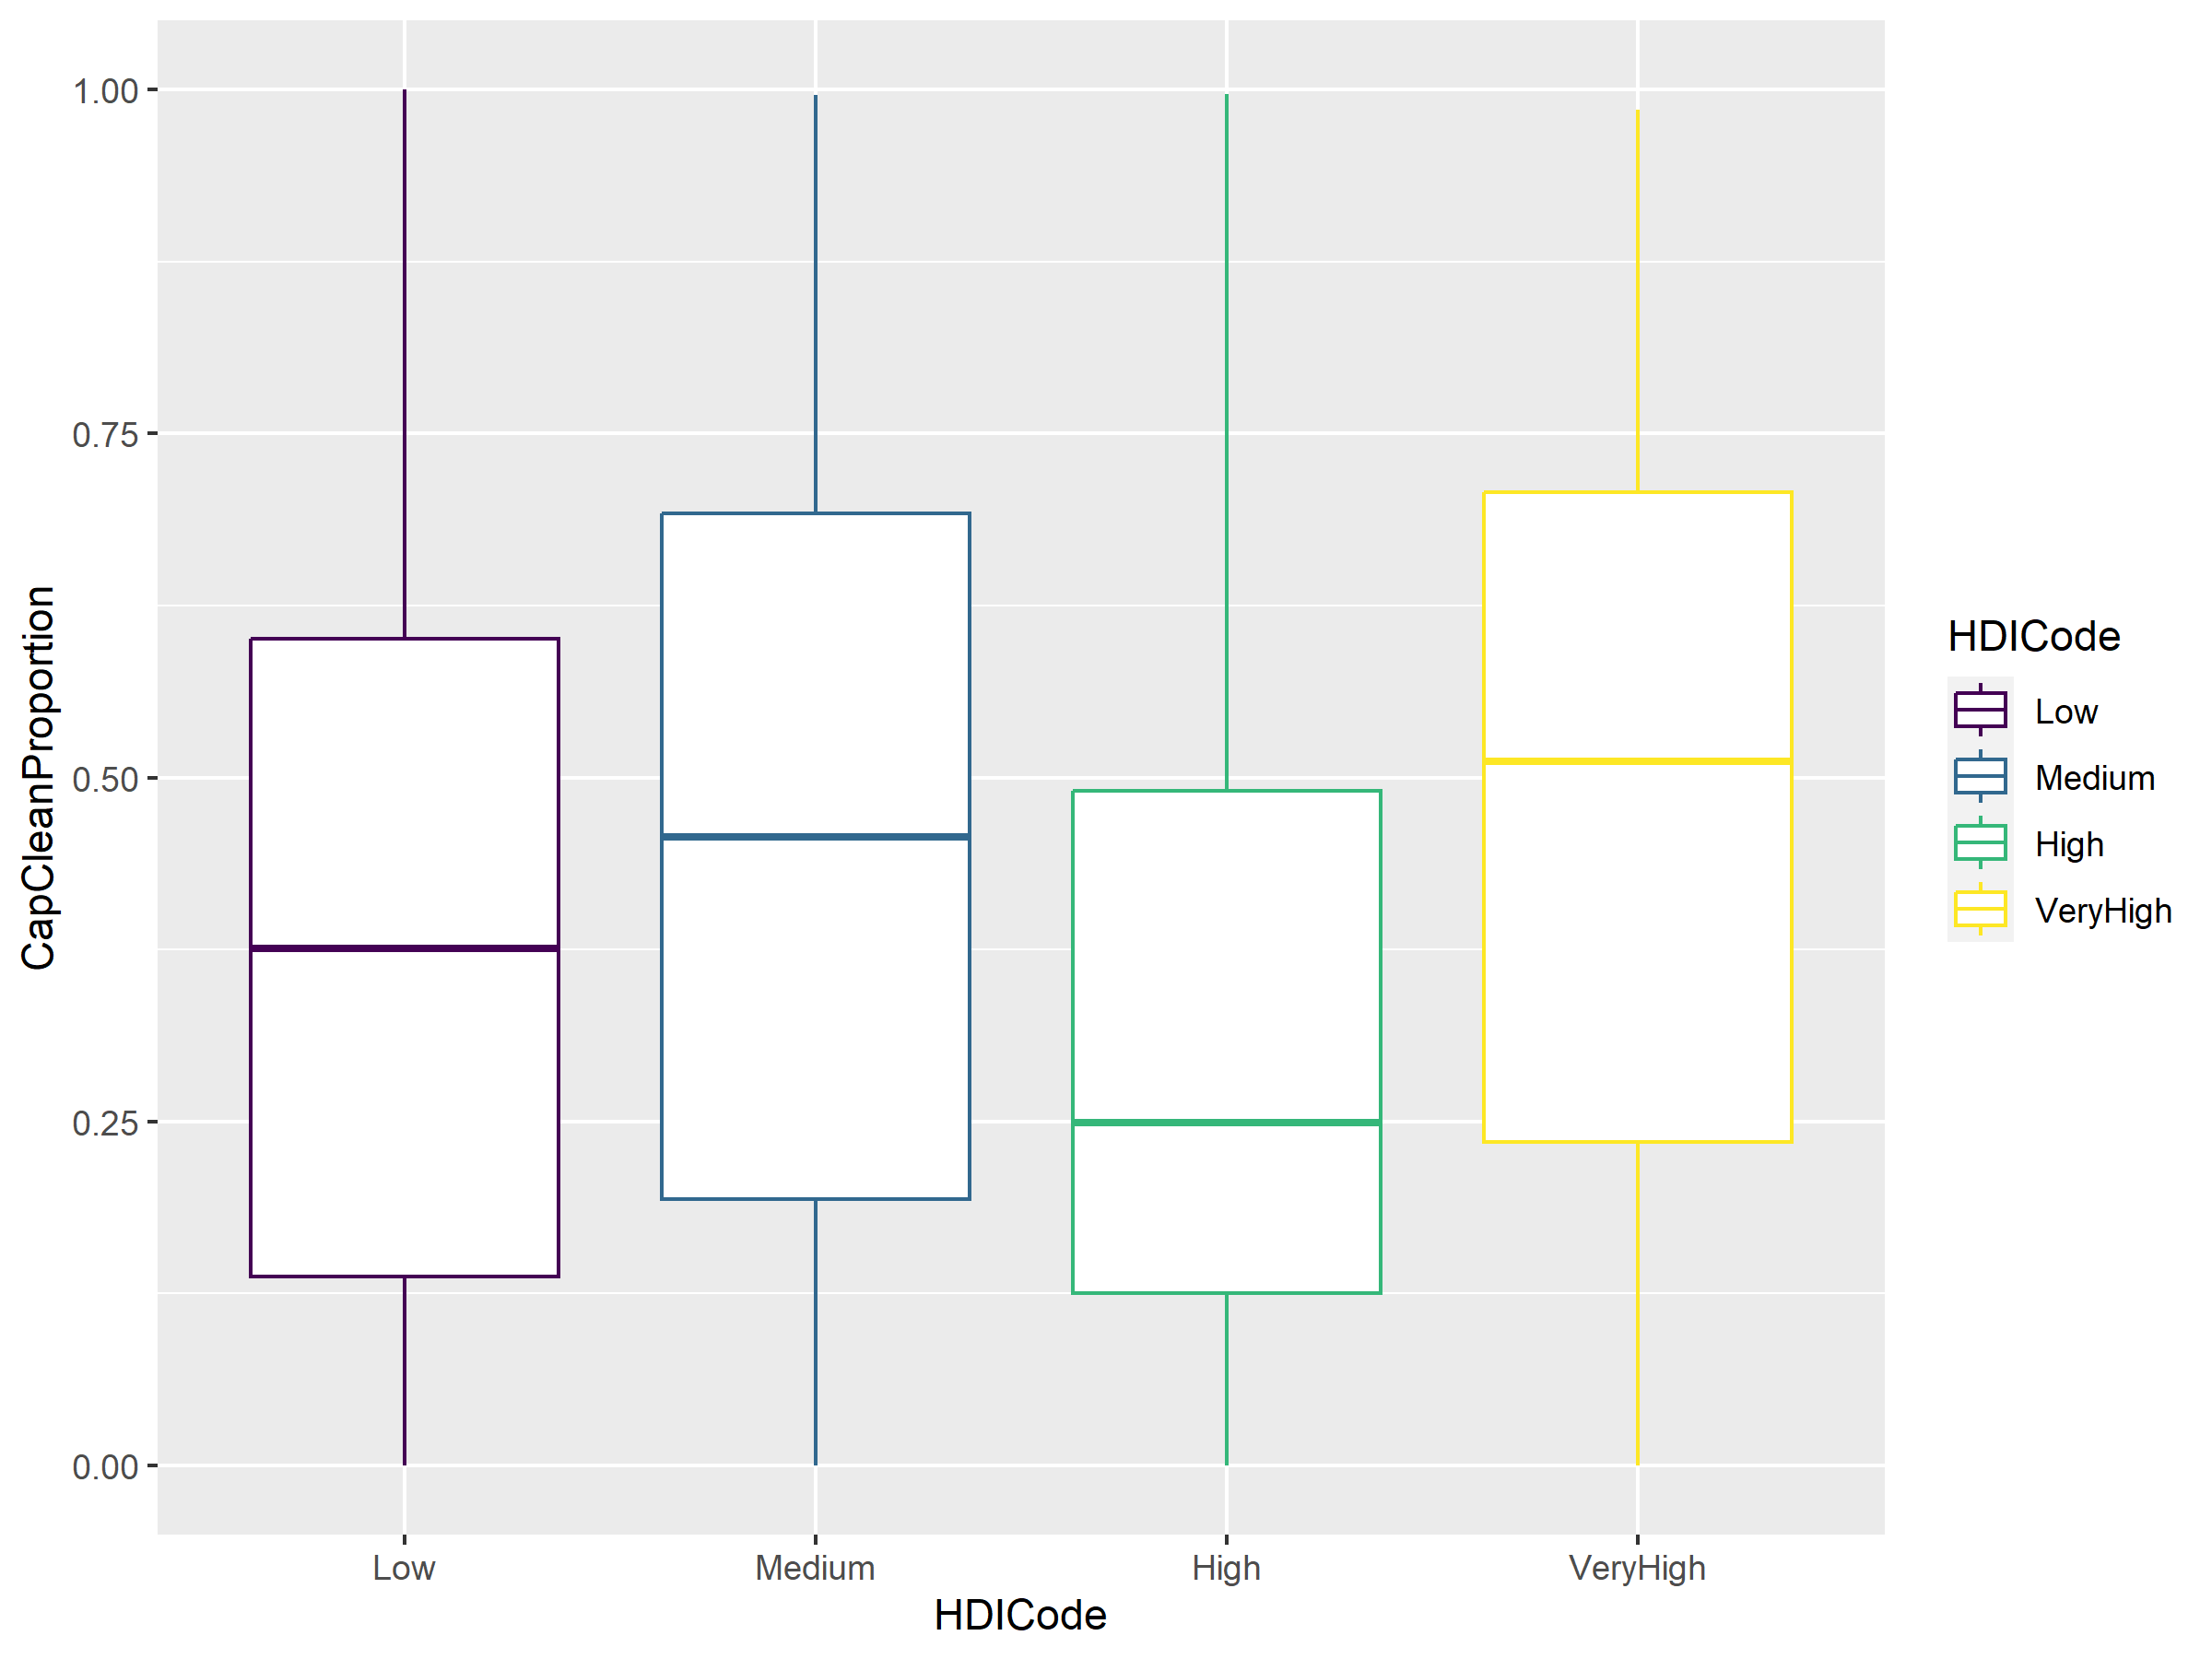

In [4]:
hdi_levels <- gsub(" ", "", hdi_levels)
elecdata.cleaned <- elecdata %>%
  mutate(HDICode = factor(gsub(" ", "", HDICode), levels = hdi_levels, ordered = T),) %>%
  select(Year, CountryCode, HDICode, CapClean, CapTotal) %>%
  na.omit()

elecdata.cleaned21 <- elecdata.cleaned[elecdata.cleaned$Year == 2021,]
elecdata.cleaned21$CapCleanProportion = elecdata.cleaned21$CapClean / elecdata.cleaned21$CapTotal
options(jupyter.plot.width=8)
ggplot(elecdata.cleaned21, aes(x = HDICode, y = CapCleanProportion, color = HDICode)) + geom_boxplot()

These boxplots show long whiskers and wide IQRs that indicate significant numbers of observations near the extremes within each group. We'll look closer at differences in group means.

In [5]:
aov.21 <- aov(CapCleanProportion ~ HDICode, data = elecdata.cleaned21)
summary(aov.21)

             Df Sum Sq Mean Sq F value Pr(>F)  
HDICode       3   0.74 0.24680   2.774 0.0428 *
Residuals   180  16.01 0.08896                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

The p-value of 0.043 indicates that HDICode group means are significantly different. Which ones differ significantly, though?

In [6]:
TukeyHSD(aov.21)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = CapCleanProportion ~ HDICode, data = elecdata.cleaned21)

$HDICode
                       diff         lwr        upr     p adj
Medium-Low       0.04711654 -0.13532638 0.22955947 0.9083918
High-Low        -0.07979373 -0.25630884 0.09672138 0.6451252
VeryHigh-Low     0.07926467 -0.08863469 0.24716404 0.6122928
High-Medium     -0.12691027 -0.29139098 0.03757044 0.1915010
VeryHigh-Medium  0.03214813 -0.12305017 0.18734644 0.9498534
VeryHigh-High    0.15905840  0.01087379 0.30724302 0.0300706


In the listed group differences, only `VeryHigh-High` has a statistically significant difference. We'll look at some diagnostic plots for our model.

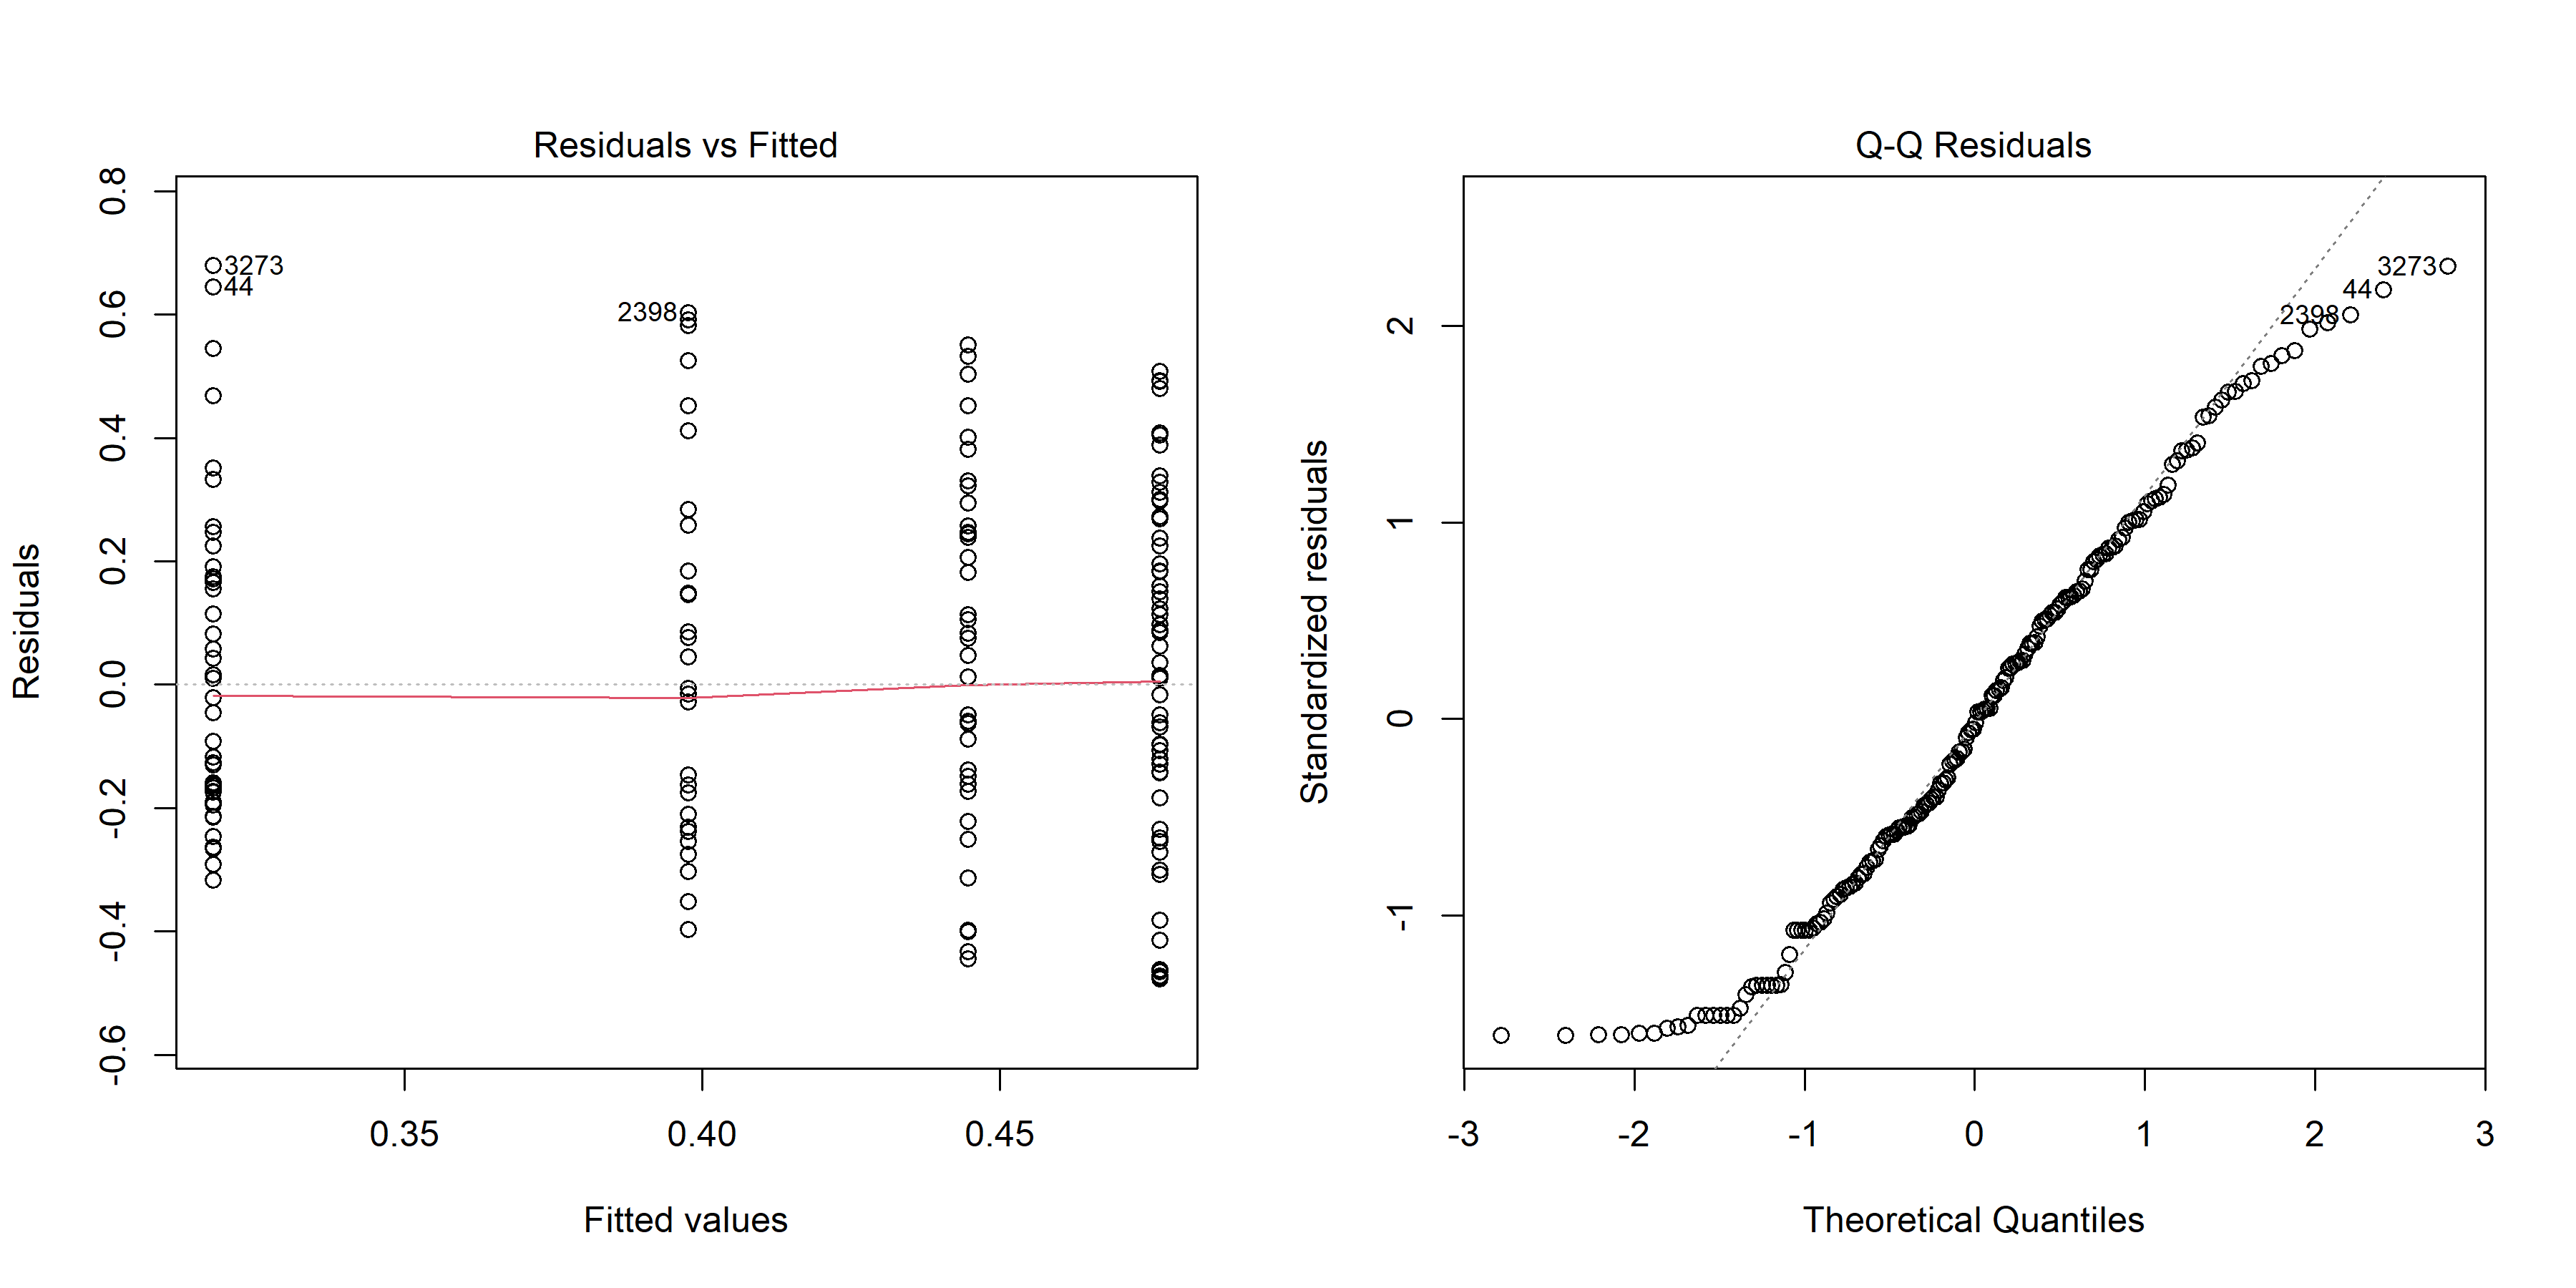

In [7]:
options(jupyter.plot.width=12)
par(mfrow = c(1, 2))
plot(aov.21, c(1, 2))

The residual plot demonstrates heavy tails. This distribution is likely not normal. This is OK for ANOVA, but we should look at normality within groups.

[1] "Shapiro-Wilk Normality Test: P-value by Group"


        Low      Medium        High    VeryHigh 
0.015076814 0.023012723 0.002651847 0.012015413 

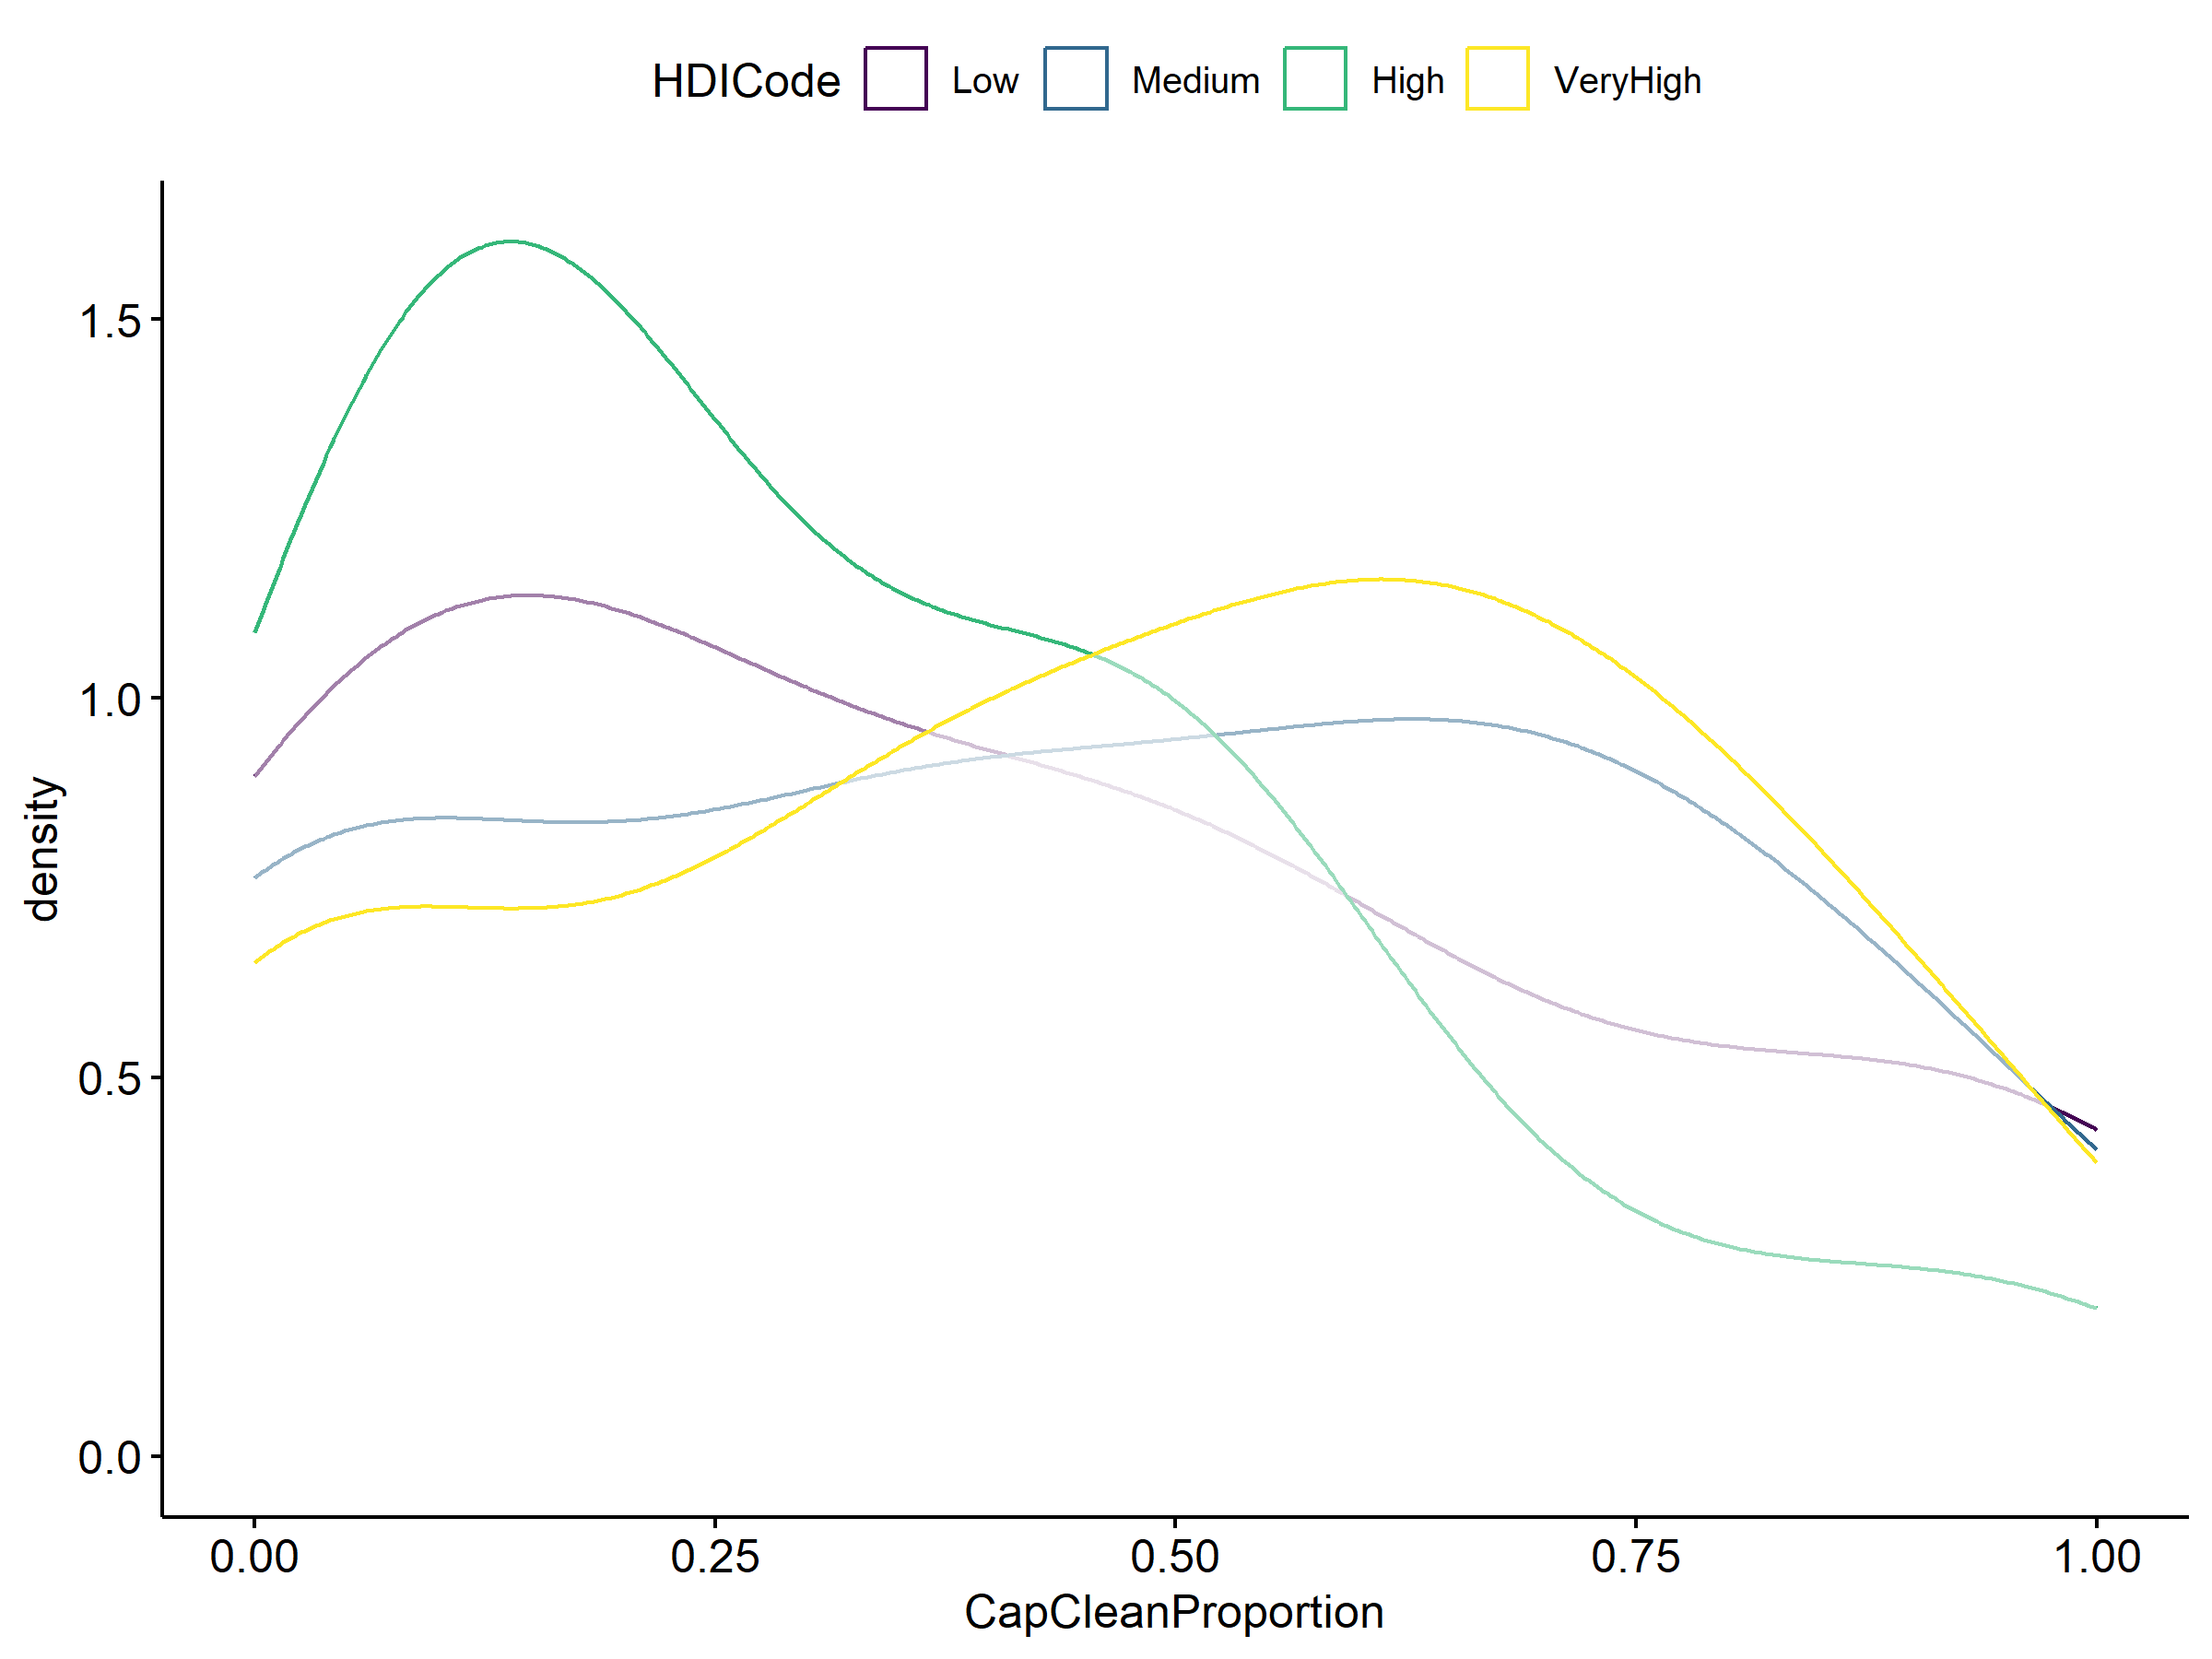

In [8]:
print("Shapiro-Wilk Normality Test: P-value by Group")
sapply(hdi_levels, function (hdi_code) {
    shap <- elecdata.cleaned21 %>% filter(HDICode == hdi_code) %>% pull(CapCleanProportion) %>% shapiro.test()
    shap$p.value
})
options(jupyter.plot.width=8)
ggdensity(elecdata.cleaned21, x = "CapCleanProportion", color = "HDICode")

The tests and visualizations show extremely non-normal distributions. It would be a good idea to use a non-parametric ANOVA test to be sure.

In [9]:
kruskal.21 <- kruskal.test(CapCleanProportion ~ HDICode, data = elecdata.cleaned21)
kruskal.21


	Kruskal-Wallis rank sum test

data:  CapCleanProportion by HDICode
Kruskal-Wallis chi-squared = 8.5472, df = 3, p-value = 0.03596


We again identify a significant difference in groups with a p-value of 0.036.

In [10]:
pairwise.wilcox.test(elecdata.cleaned21$CapCleanProportion, elecdata.cleaned21$HDICode,
                     p.adjust.method = "BH")

Warning in wilcox.test.default(xi, xj, paired = paired, ...):
cannot compute exact p-value with ties
Warning in wilcox.test.default(xi, xj, paired = paired, ...):
cannot compute exact p-value with ties
Warning in wilcox.test.default(xi, xj, paired = paired, ...):
cannot compute exact p-value with ties



	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  elecdata.cleaned21$CapCleanProportion and elecdata.cleaned21$HDICode 

         Low   Medium High 
Medium   0.549 -      -    
High     0.549 0.212  -    
VeryHigh 0.369 0.549  0.019

P value adjustment method: BH 

Similiarly, the pairwise Wilcoxon comparisons identify only the `VeryHigh-High` difference as significant with p-value of 0.019.

## Trends

Let's reshape the data so that we may look at clean energy generation proportions by year and HDI code. Then, we'll plot each series to compare.

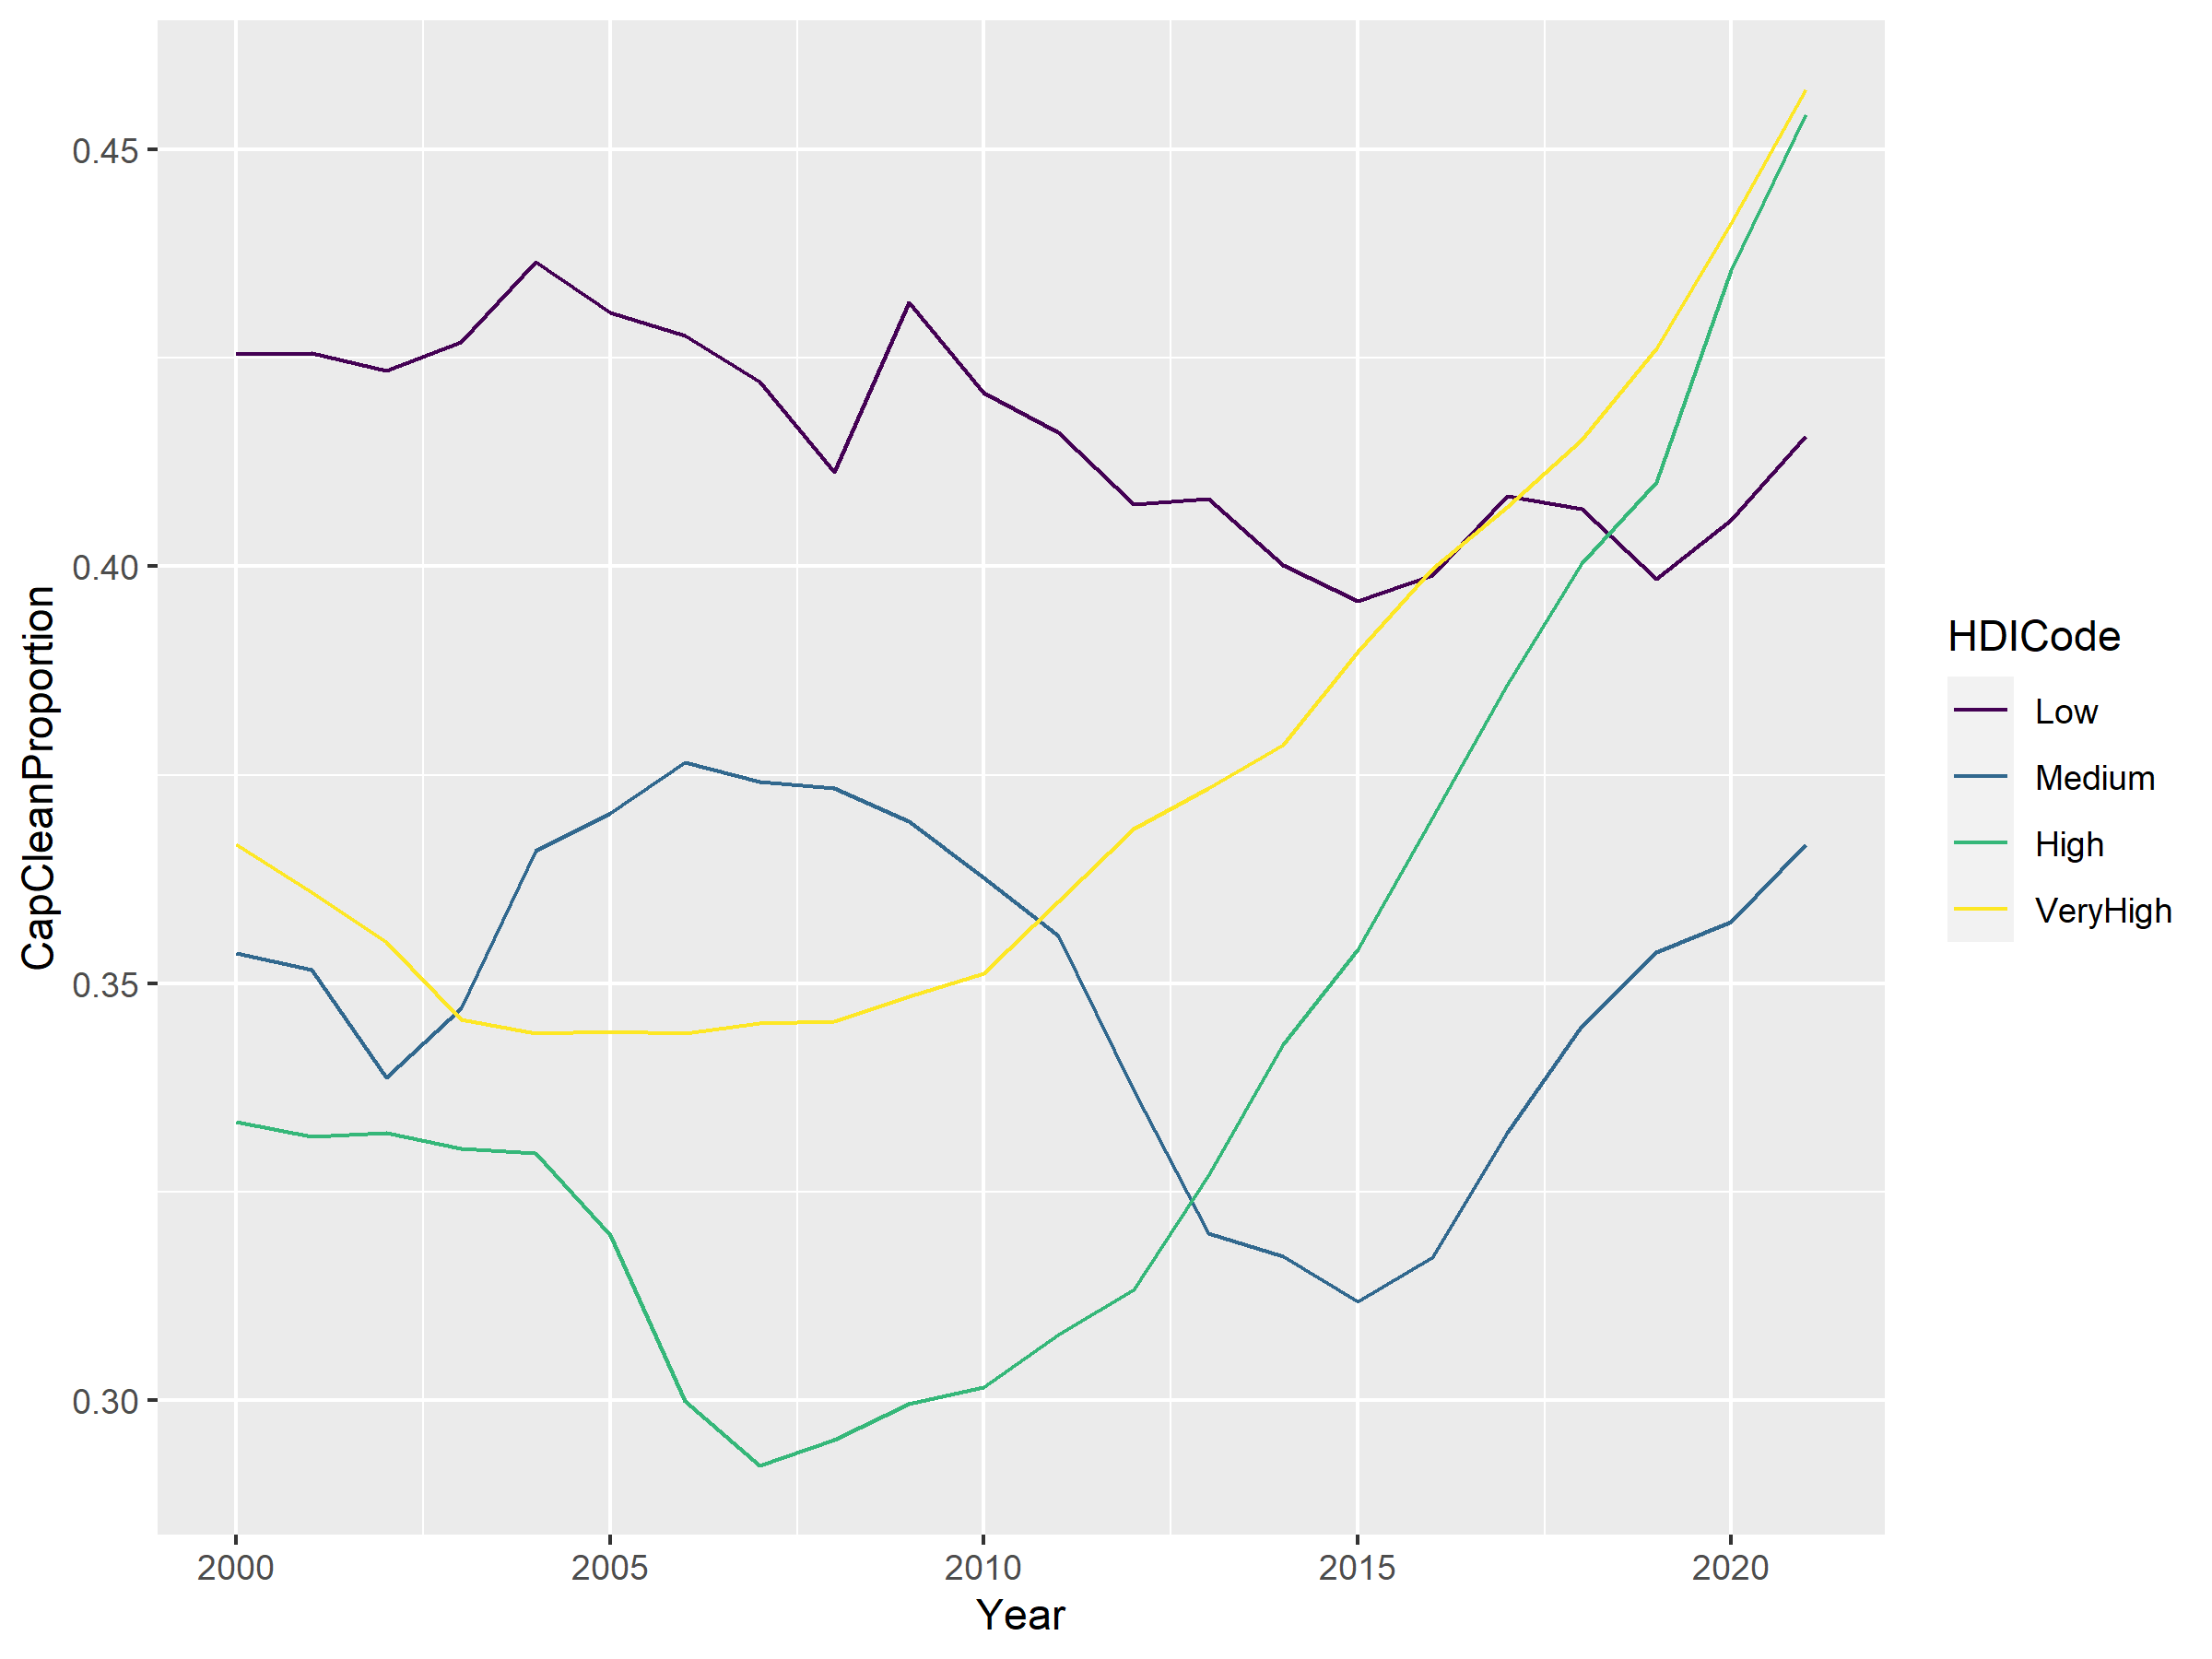

In [11]:
capclean.grouped <- elecdata.cleaned %>%
  group_by(Year, HDICode) %>%
  summarise(CapCleanProportion = sum(CapClean) / sum(CapTotal), .groups = "drop_last")

ggplot(data = capclean.grouped, aes(x = Year, y = CapCleanProportion, color = HDICode)) +
  geom_line()

The plot shows clear upward trends in clean capacity proportion for High and Very High HDI nations. Overall, the trend for Low and Medium appears quite flat. Let's zoom in a bit.

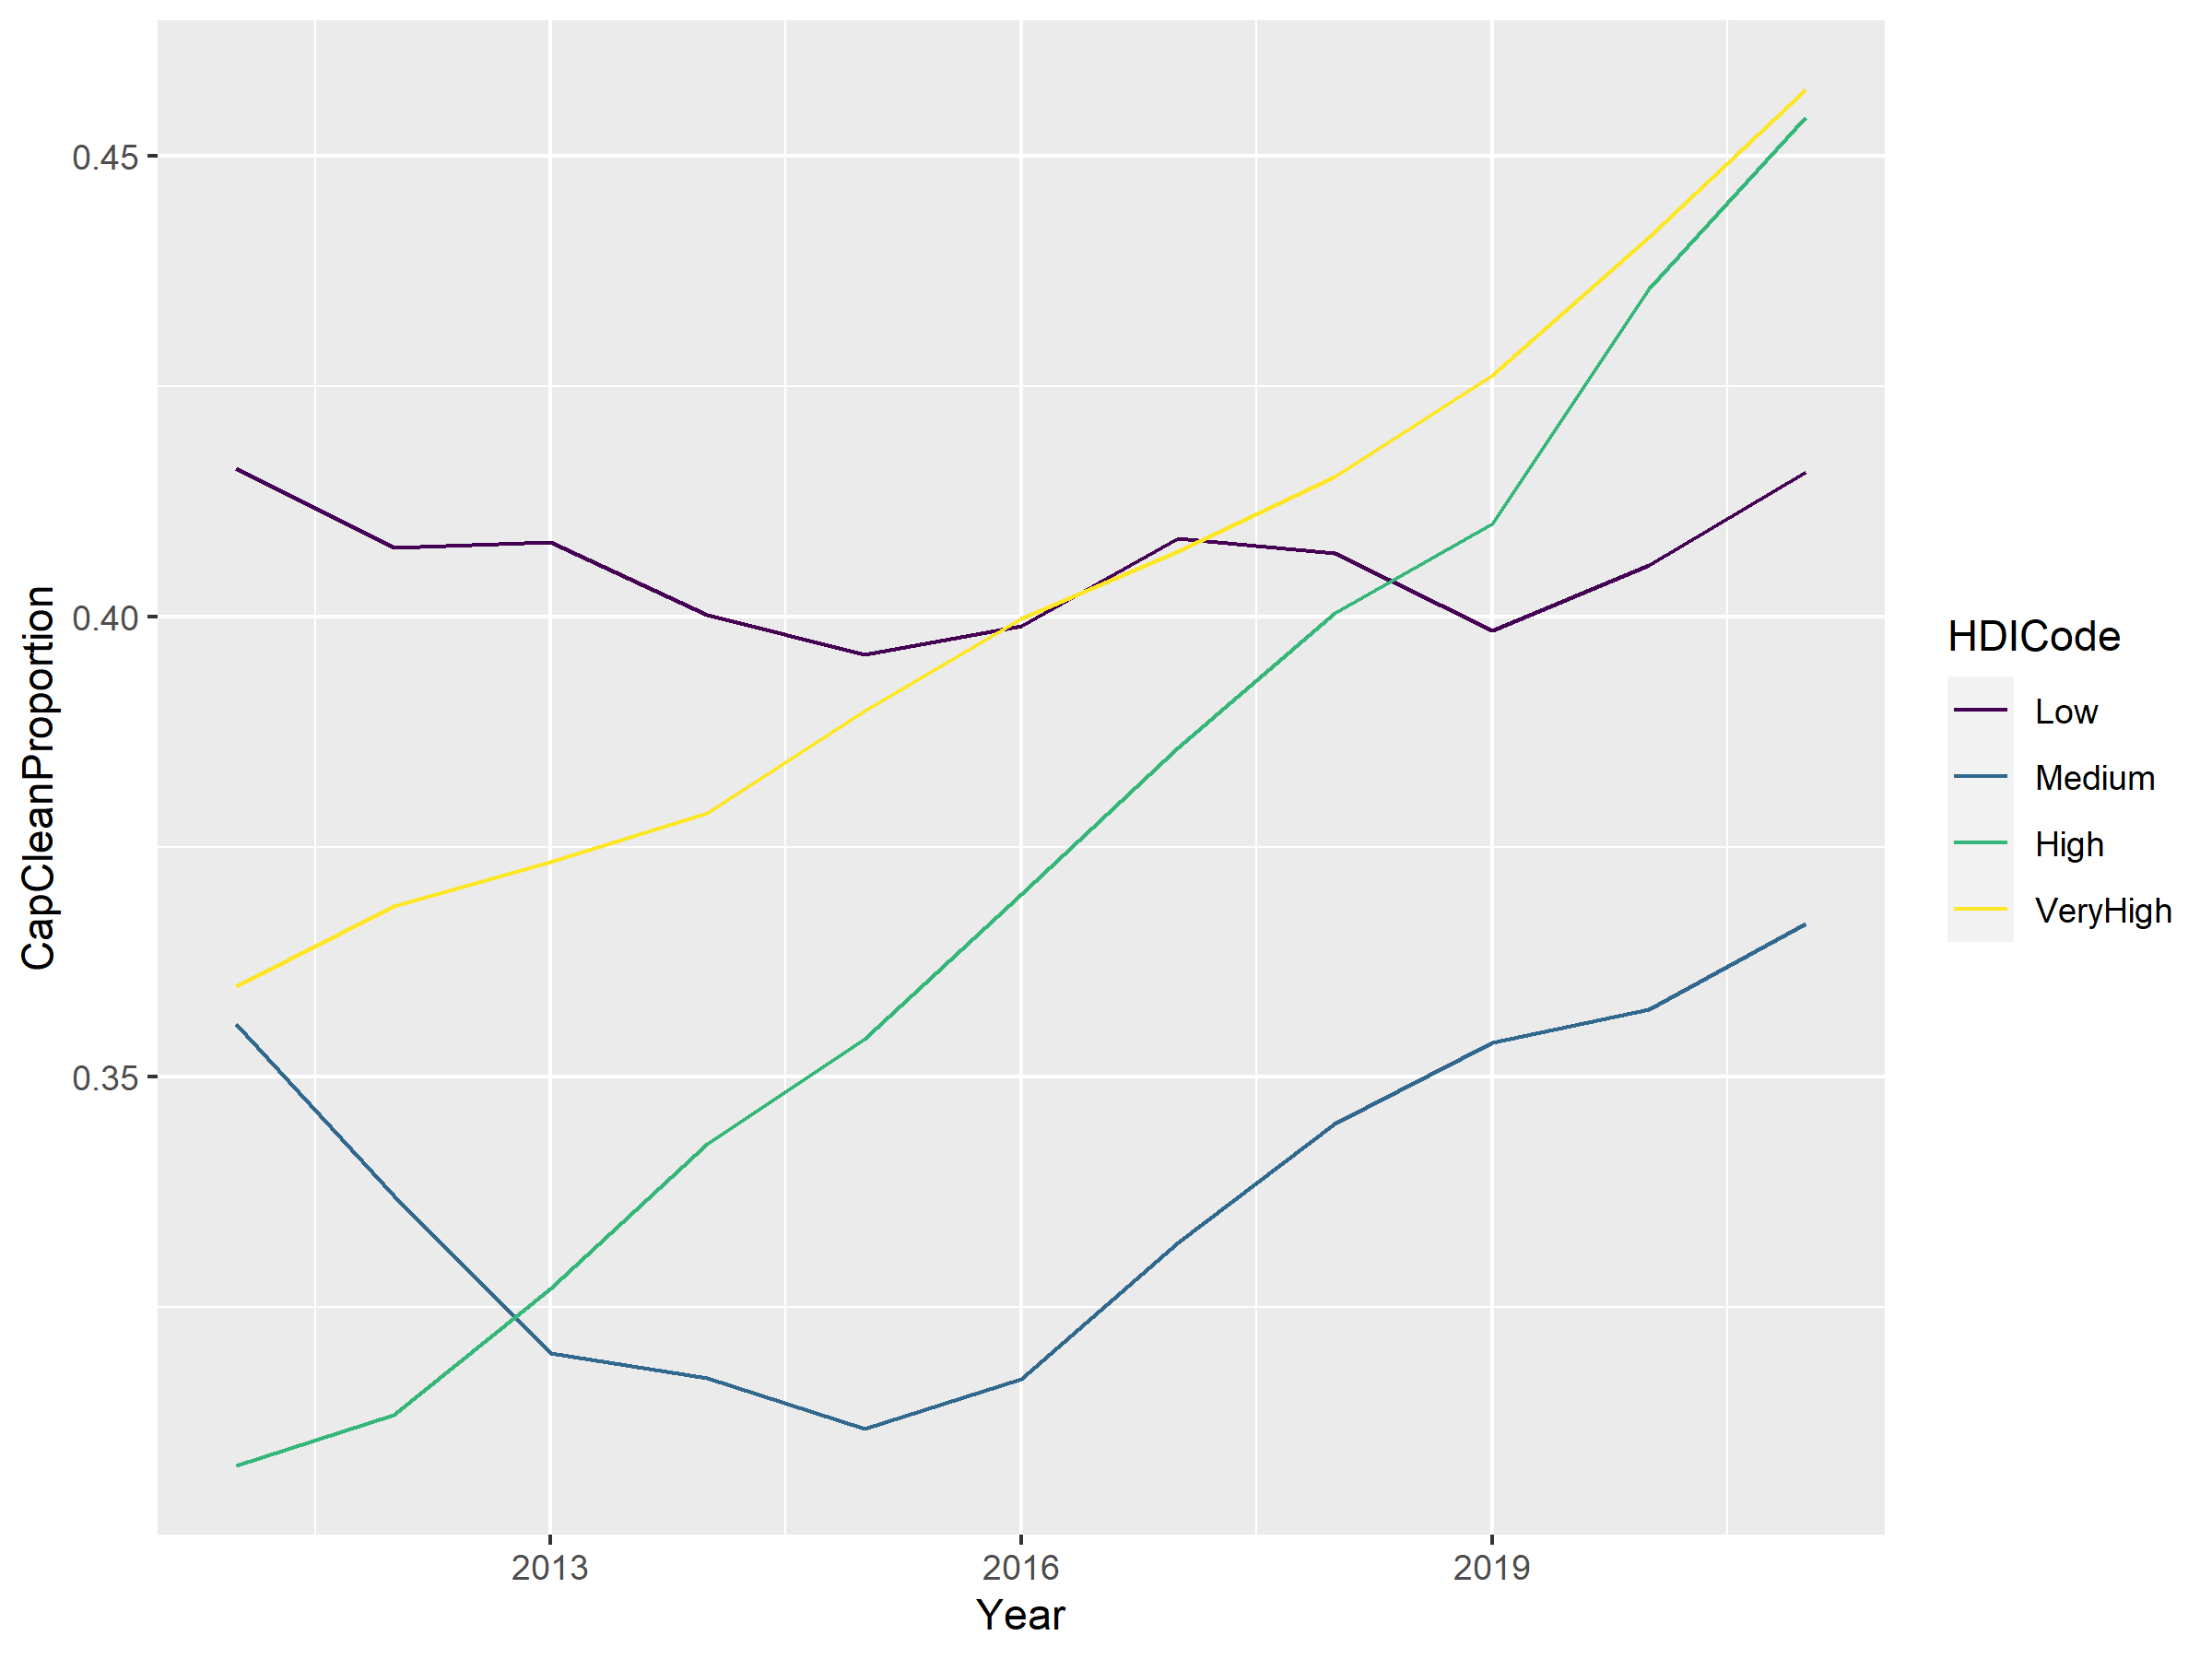

In [12]:
ggplot(data = capclean.grouped[capclean.grouped$Year > 2010,], 
       aes(x = Year, y = CapCleanProportion, color = HDICode)) +
  geom_line()

Since 2010, the trend for Medium HDI looks a bit more upward, but Low HDI looks to have had practically no change.

## Next Steps

Next steps may include, but are not limited to:
* Analysis of groups based on geography or economic union (South America, EU, etc.)
* Change detection (CUSUM) to determine if we can identify when changes in energy capacity were made
* Correlation analysis
* Time series modeling (ARIMA, ARIMAX, VAR, etc.)